# Importing the important libraries

In [1]:
import pandas
import pandas as pd
import numpy
import sys
%matplotlib inline
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import numpy as np
import time
import sklearn
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
# fix random seed for reproducibility
plt.rcParams['figure.figsize'] = (18, 12)
from sklearn.datasets.samples_generator import make_blobs
from pandas.plotting import parallel_coordinates

# Data Set

## Load the dataset


To download the sataset from the web follow this is the link https://archive.ics.uci.edu/ml/datasets/Spambase

In [2]:
# Link to data on the disk
raw_data = np.genfromtxt("https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data", delimiter=',')
print('The dataset has been loaded')

The dataset has been loaded


In [3]:
# print(the number of examples and the dimenstion in this dataset
# Notice that the last feature in this dataset is the target
data = raw_data
size = np.shape(data)
print(' Number of features , number of examples = ', size)
np.random.shuffle(data)
X = data[:, 0:-1]
y = data[:, -1]

 Number of features , number of examples =  (4601, 58)


## Peprocess the data

In [4]:
df = pandas.DataFrame(X,y)

## Prepare the data for classification

In [5]:
dataset = df.values

In [6]:
from sklearn import preprocessing
# for training data
X = dataset.astype(float)
features = preprocessing.scale(X)
target = y

In [7]:
X.shape

(4601, 57)

## Feature Selection

In [8]:
from sklearn.model_selection import train_test_split
# Extracting 20% validation data
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.40, random_state=17)

## Preproccing

In [9]:
print('Number of training examples',len(X_train))
print('Number of validation examples',len(X_test))

Number of training examples 2760
Number of validation examples 1841


In [10]:
from sklearn import preprocessing
# normalize the data attributes
X_train = preprocessing.normalize(X_train)
#X_test = preprocessing.normalize(X_test)
# standardize the data attributes
X_train = preprocessing.scale(X_train)
#X_test = preprocessing.scale(X_test)

# Neural Networks

In [11]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from keras.utils import np_utils
# The layers where we want to prune
N1 = 20 # 20
N2 = 20
labelsTrain = np_utils.to_categorical(y_train)
model = Sequential()
model.add(Dense(N1,
                input_shape=(57,), 
                activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(N2, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation="softmax"))
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')
start_time = time.time()
model.fit(X_train, labelsTrain, verbose=0, batch_size=1, epochs=100)
print("The time for training NN is  %s seconds " % (time.time() - start_time))
loss, accuracy = model.evaluate(X_train, labelsTrain, batch_size=1, verbose=0)
print("Test fraction correct (NN-loss) = {:.2f}".format(loss))
print("Test fraction correct (NN-Accuracy) = {:.2f}".format(accuracy))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
The time for training NN is  278.4171860218048 seconds 
Test fraction correct (NN-loss) = 0.09
Test fraction correct (NN-Accuracy) = 0.98


In [12]:
modelBuckup = model

## The Architecture of the Model

In [13]:
modelBuckup.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                1160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 42        
Total params: 1,622
Trainable params: 1,622
Non-trainable params: 0
_________________________________________________________________


# Direct Method for Pruning Weights

In [14]:
# specify the layer should have N1 and N2 weights
L = 2

## Pruning the weights

In [15]:
startD = time.time()
N_arry = np.zeros((N1*N2))
N_arryD = np.zeros((N1*N2))
noExamples = len(X_train)
NL = np.zeros(noExamples)
Threshold = 0
constant=1
for k in range(noExamples):
    count = 0
    for i in range(N1):
        for j in range(N2):
            loss, accuracy = modelBuckup.evaluate(X_train[k:k+1], labelsTrain[k:k+1], 
                                                 batch_size=1, verbose=0)
        # Prune the neuron in the layer
            All_weights=modelBuckup.get_weights()
            temp = All_weights[L][i][j]
            All_weights[L][i][j] = 0
            modelBuckup.set_weights(All_weights)
            loss_New, accuracy_New = modelBuckup.evaluate(X_train[k:k+1], labelsTrain[k:k+1], 
                                                         batch_size=1, verbose=0)
            delta = loss_New - loss
            #reward = max(0,Threshold + delta)/constant
            #print('delta = ', delta)
            All_weights[L][i][j]= temp  # before
            N_arry[count] = max(delta,0) 
            count = count +1
            modelBuckup.set_weights(All_weights)
                #print(delta)
    NL[k]=np.argmax(N_arry) # chosen weight at every iteration
    N_arryD = N_arryD + N_arry 
endD = time.time()
print("Execution time ",endD - startD)

Execution time  2766.4027218818665


## The single weight that has been chosen by direct method

Practically we choose k weights that have high rewards but the purpose of this file to show the computation time and which is the method be able to choose best arm comparing to direct method.

In [16]:
reshapeD = N_arryD.reshape(N1,N2)
D = np.argmax(N_arryD)
Di,Dj = np.unravel_index(D, reshapeD.shape)
print("The index of chosen  W_ji is = ", Dj, Di)

The index of chosen  W_ji is =  11 6


Set the number of rounding same for all methods

In [17]:
Round = 1800  # will be the same for all methods

# Random policy


Random policy  or Epsilon-first strategy : during T rounds, sample a random arm (uniform sampling), and then choose the best arms.

## Pruning the Weights

In [18]:
startP = time.time()
N_arry = np.zeros(N1*N2)
#noExamples = 100
NL = np.zeros(Round)
RP = np.zeros(Round)
Avg_Accumaltive_RP = np.zeros(N1*N2)
p_reshape = Avg_Accumaltive_RP.reshape(N1,N2)
Count_RP = np.ones(N1*N2)
import random
count = 0

# uniform sampling 
for j in range(Round):
            b = random.randint(0,noExamples-1)  
            loss, accuracy = modelBuckup.evaluate(X_train[b:b+1], labelsTrain[b:b+1], batch_size=1, verbose=0)
            ind = random.randint(0,N1*N2-1)
            i,k = np.unravel_index(ind, p_reshape.shape)
            #print(i,k)
            All_weights=modelBuckup.get_weights()
            temp = All_weights[2][i][k]
            All_weights[2][i][k] = 0
            modelBuckup.set_weights(All_weights)
            Count_RP[ind]=Count_RP[ind]+1
            loss_New, accuracy_New = modelBuckup.evaluate(X_train[b:b+1], labelsTrain[b:b+1], batch_size=1, verbose=0)
            delta = loss_New - loss
            #print(delta)
            reward = max(0,Threshold + delta)/constant
            #print(reward)
            val = Count_RP[ind]
            Avg_Accumaltive_RP[ind] = (val-1)/val * Avg_Accumaltive_RP[ind] + 1/val * reward
            All_weights[2][i][k] = temp
            modelBuckup.set_weights(All_weights)
            RP[j]=ind

# Exploting 
# The  weight that has been chosen by Random policy method

reshapeRP = Avg_Accumaltive_RP.reshape(N1,N2)
P = np.argmax(Avg_Accumaltive_RP)
endP = time.time()
print("Execution time = ",endP - startP)
Pi,Pj = np.unravel_index(P, reshapeRP.shape)
print("\n The index of chosen  W_ji is = ", Pj, Pi)

Execution time =  4.155773162841797

 The index of chosen  W_ji is =  11 19


# Epsilon Greedy

## Pruning the Weights

In [19]:
startG = time.time()
N_arry = np.zeros(N1*N2)
#noExamples = 100
NL = np.zeros(Round)
ep = np.zeros(Round)
Avg_Accumaltive_R_EGN = np.zeros(N1*N2)
p_reshape = Avg_Accumaltive_R_EGN.reshape(N1,N2)
Count_EGN = np.ones(N1*N2)
import random
epsilon=0.5
count = 0
for i in range(N1): 
    for j in range(N2):
            loss, accuracy = modelBuckup.evaluate(X_train[1:10], labelsTrain[1:10], batch_size=1, verbose=0)
        # Prune the neuron in the layer
            All_weights=modelBuckup.get_weights()
            temp = All_weights[2][i][j]
            All_weights[2][i][j] = 0 
            modelBuckup.set_weights(All_weights)
            loss_New, accuracy_New = modelBuckup.evaluate(X_train[1:10], labelsTrain[1:10], batch_size=1, verbose=0)
            delta = loss_New - loss
            reward = max(0,Threshold + delta)/constant
            All_weights[2][i][j]= temp
            Avg_Accumaltive_R_EGN[count] = reward
            modelBuckup.set_weights(All_weights)
            count = count+1
for j in range(N1+N2-1, Round):
            b = random.randint(0,noExamples-1)  
            loss, accuracy = modelBuckup.evaluate(X_train[b:b+1], labelsTrain[b:b+1], batch_size=1, verbose=0)
        # Prune the neuron in the layer
            if (epsilon>random.uniform(0, 1)):
                ind = np.argmax(Avg_Accumaltive_R_EGN)
            else:
                ind = random.randint(0,N1*N2-1)
            i,k = np.unravel_index(ind, p_reshape.shape)
            #print(i,k)
            All_weights=modelBuckup.get_weights()
            temp = All_weights[2][i][k]
            All_weights[2][i][k] = 0
            modelBuckup.set_weights(All_weights)
            Count_EGN[ind]=Count_EGN[ind]+1
            loss_New, accuracy_New = modelBuckup.evaluate(X_train[b:b+1], labelsTrain[b:b+1], batch_size=1, verbose=0)
            delta = loss_New - loss
            #print(delta)
            reward = max(0,Threshold + delta)/constant
            #print(reward)
            val = Count_EGN[ind]
            Avg_Accumaltive_R_EGN[ind] = (val-1)/val * Avg_Accumaltive_R_EGN[ind] + 1/val * reward
            All_weights[2][i][k] = temp
            modelBuckup.set_weights(All_weights)
            ep[j]=ind
endG = time.time()
print("Execution time ",endG - startG)

Execution time  6.4766600131988525


## The single weight that has been chosen by Epsilon Greedy method

Practically we choose k weights that have high rewards but the purpose of this file to show the computation time and which is the method be able to choose best arm comparing to direct method.

In [20]:
reshapeG = Avg_Accumaltive_R_EGN.reshape(N1,N2)
G = np.argmax(Avg_Accumaltive_R_EGN)
Gi,Gj = np.unravel_index(G, reshapeG.shape)
print("The index of chosen  W_ji is = ", Gj, Gi)

The index of chosen  W_ji is =  0 8


# UCB1

## Pruning Weights

In [21]:
startU = time.time()
N_arry = np.zeros(N1*N2)
NL = np.zeros(Round)
Avg_Accumaltive_UCB = np.zeros(N1*N2)
Count_UCB = np.ones(N1*N2)
UCB1 = np.zeros(Round)
p_reshape = Avg_Accumaltive_UCB.reshape(N1,N2)
count = 0
import random
tau=4
for i in range(N1): 
    for j in range(N2):
            loss, accuracy = modelBuckup.evaluate(X_train[1:10], labelsTrain[1:10], batch_size=1, verbose=0)
            All_weights=modelBuckup.get_weights()
            temp = All_weights[2][i][j]
            All_weights[2][i][j] = 0 
            modelBuckup.set_weights(All_weights)
            loss_New, accuracy_New = modelBuckup.evaluate(X_train[1:10], labelsTrain[1:10], batch_size=1, verbose=0)
            delta = loss_New - loss
            reward = max(0,Threshold + delta)/constant
            All_weights[2][i][j]= temp
            Avg_Accumaltive_UCB[count] = reward
            modelBuckup.set_weights(All_weights)
            count = count+1
for j in range(N1+N2-1, Round):
            b = random.randint(0,noExamples-1)  
            loss, accuracy = modelBuckup.evaluate(X_train[b:b+1], labelsTrain[b:b+1], batch_size=1, verbose=0)
            padding = np.sqrt(2*Count_UCB.sum()/Count_UCB)
            ucb = Avg_Accumaltive_UCB + padding
            ind = np.argmax(ucb)
            Count_UCB[ind] = Count_UCB[ind] + 1
            i,k = np.unravel_index(ind, p_reshape.shape)
            All_weights=modelBuckup.get_weights()
            temp = All_weights[2][i][k]
            All_weights[2][i][k] = 0           
            modelBuckup.set_weights(All_weights)
            loss_New, accuracy_New = modelBuckup.evaluate(X_train[b:b+1], labelsTrain[b:b+1], batch_size=1, verbose=0)
            delta = loss_New - loss
            reward = max(0,Threshold + delta)/constant
            All_weights[2][i][k] = temp
            modelBuckup.set_weights(All_weights)
            val = Count_UCB[ind]
            Avg_Accumaltive_UCB[ind] = (val-1)/val * Avg_Accumaltive_UCB[ind] + 1/val * reward
            modelBuckup.set_weights(All_weights)
            UCB1[j]=ind
endU = time.time()
print("Execution time ",endU - startU)

Execution time  7.695124864578247


## The single weight that has been chosen by UCB1 method

Practically we choose k weights that have high rewards but the purpose of this file to show the computation time and which is the method be able to choose best arm comparing to direct method.

In [22]:
reshapeU = Avg_Accumaltive_UCB.reshape(N1,N2)
U = np.argmax(Avg_Accumaltive_UCB)
Ui,Uj = np.unravel_index(U, reshapeU.shape)
print("The index of chosen  W_ji is = ", Uj, Ui)

The index of chosen  W_ji is =  1 11


# Thompson Sampling

## Pruning weights

In [23]:
startT = time.time()
N_arry = np.zeros(N1*N2)
NL = np.zeros(Round)
Avg_Accumaltive_TS = np.zeros(N1*N2)
Count_TS = np.ones(N1*N2)
TS = np.zeros(Round)
p_reshape = Avg_Accumaltive_TS.reshape(N1,N2)
count = 0
success = np.zeros(N1*N2)
failure = np.zeros(N1*N2)
for i in range(N1): 
    for j in range(N2):
            loss, accuracy = modelBuckup.evaluate(X_train[1:10], labelsTrain[1:10], batch_size=1, verbose=0)
        # Prune the neuron in the layer
            All_weights=modelBuckup.get_weights()
            temp = All_weights[2][i][j]
            All_weights[2][i][j] = 0 
            modelBuckup.set_weights(All_weights)
            loss_New, accuracy_New = modelBuckup.evaluate(X_train[1:10], labelsTrain[1:10], batch_size=1, verbose=0)
            delta = loss_New - loss
            if(delta>0):
                reward = 1
                success[i] = success[i]+1
            else:
                reward = 0
                failure[i] = failure[i]+1                        
            All_weights[2][i][j]= temp
            Avg_Accumaltive_TS[count] = reward
            modelBuckup.set_weights(All_weights)
            count = count+1
for j in range(N1+N2-1, Round):
            b = random.randint(0,noExamples-1)  
            loss, accuracy = modelBuckup.evaluate(X_train[b:b+1], labelsTrain[b:b+1], batch_size=1, verbose=0)
        # Prune the neuron in the layer 
            ind = np.argmax(np.random.beta(1+success, 1+failure))
            Count_TS[ind] = Count_TS[ind] + 1
            i,k = np.unravel_index(ind, p_reshape.shape)
            All_weights=modelBuckup.get_weights()
            temp = All_weights[2][i][k]
            All_weights[2][i][k] = 0                     
            modelBuckup.set_weights(All_weights)
            loss_New, accuracy_New = modelBuckup.evaluate(X_train[b:b+1], labelsTrain[b:b+1], batch_size=1, verbose=0)
            delta = loss_New - loss
            if(delta>0):
                reward = 1
                success[i] = success[i]+1
            else:
                reward = 0
                failure[i] = failure[i]+1            
            All_weights[2][i][k] = temp
            modelBuckup.set_weights(All_weights)          
            val = Count_TS[ind]
            Avg_Accumaltive_TS[ind] = (val-1)/val * Avg_Accumaltive_TS[ind] + 1/val * reward
            TS[j]=ind
endT = time.time()
print("Execution time ",endT - startT)

Execution time  7.017300844192505


## The single weight that has been chosen by Thompson Sampling method

Practically we choose k weights that have high rewards but the purpose of this file to show the computation time and which is the method be able to choose best arm comparing to direct method.

In [24]:
reshapeT = Avg_Accumaltive_TS.reshape(N1,N2)
T = np.argmax(Avg_Accumaltive_TS)
Ti,Tj = np.unravel_index(T, reshapeT.shape)
print("The index of chosen  W_ji is = ", Tj, Ti)

The index of chosen  W_ji is =  0 0


# Successive Rejects

For a K-armed bandit, Successive Rejects operates in (K − 1) phases. At the end of each phase, the arm with the lowest average reward is discarded. Thus, at the end of phase (K − 1) only one arm survives, and this arm is recommended.


## Pruning weights

In [25]:
startS = time.time()
N_arry = np.zeros(N1*N2)
NL = np.zeros(noExamples)
sr = []
Avg_Accumaltive_SR = np.zeros(N1*N2)
Avg_Accumaltive_SR2 = np.zeros(N1*N2)
Avg_Accumaltive_SR1 = np.zeros(N1*N2)
p_reshape = Avg_Accumaltive_SR2.reshape(N1,N2)
check_array = np.ones((N1,N2))
Count_SR = np.ones(N1*N2)
A = [0]
Nk = []
K = N1*N2
Log = 0.5
for k in range(K):
    d = k+2
    Log = Log + 1/d
for k in range(K-2):
    d = k+1
    nK = int(np.floor(1/Log * (Round-K)/(K+1-d)))
    if nK!=0:
        A.append(nK)
A.sort(reverse=False)
#print("The round of the phases : ",A)
g=0
for a in A:
    h = a - g
    g = a
    Nk.append(h)
    count=0
    #print(a)
    for n in range(h):
        c=0
        for i in range(N1):
            for j in range(N2):
                if check_array[i][j]==1:
                    b = random.randint(0,noExamples-1) 
                    loss, accuracy = modelBuckup.evaluate(X_train[b:b+1], labelsTrain[b:b+1], batch_size=1, verbose=0)
                    All_weights=modelBuckup.get_weights()
                    temp = All_weights[2][i][j]
                    All_weights[2][i][j] = 0
                    modelBuckup.set_weights(All_weights)
                    loss_New, accuracy_New = modelBuckup.evaluate(X_train[b:b+1], labelsTrain[b:b+1], batch_size=1, verbose=0)
                    delta = loss_New - loss
                    reward = max(0,Threshold + delta)/constant
                    All_weights[2][i][j] = temp
                    modelBuckup.set_weights(All_weights)
                    val = Count_SR[c]
                    #print(reward)
                    Avg_Accumaltive_SR[c] = (val-1)/val * Avg_Accumaltive_SR[c] + 1/val * reward
                    All_weights[2][i][j] = temp
                    modelBuckup.set_weights(All_weights)
                    count = count+1
                    c = c + 1    
        Avg_Accumaltive_SR2=Avg_Accumaltive_SR2+Avg_Accumaltive_SR
        Avg_Accumaltive_SR1=Avg_Accumaltive_SR2.copy()
    ind = np.argmin(Avg_Accumaltive_SR2)
    Avg_Accumaltive_SR2[ind] = 100
    #print(Avg_Accumaltive_SR)
    s,t = np.unravel_index(ind, p_reshape.shape)
    ###check_array[s][t]=0
    sr.append(ind)
endS = time.time()
print("Execution time ",endS - startS)
#print("A = ", A)
#print("Nk = ", Nk)

Execution time  86.46844506263733


In [26]:
Avg_Accumaltive_SR3 = np.abs(100-Avg_Accumaltive_SR2)

## The single weight that has been chosen by Successive Rejects method

Practically we choose k weights that have high rewards but the purpose of this file to show the computation time and which is the method be able to choose best arm comparing to direct method.

In [27]:
reshapeS = Avg_Accumaltive_SR3.reshape(N1,N2)
S = np.argmax(Avg_Accumaltive_SR3)
Si,Sj = np.unravel_index(S, reshapeS.shape)
print("The index of chosen  W_ji is = ", Sj, Si)

The index of chosen  W_ji is =  17 13


# Best Arm Identification: A Unified Approach to Fixed Budget and Fixed Confidence



The implimetation based on:




K. Terayama, H. Iwata, M. Araki, Y. Okuno, K. Tsuda, "Machine Learning Accelerates MD-based Binding-Pose Prediction between Ligands and Proteins", Bioinformatics, 2017.


Gabillon, V.; Ghavamzadeh, M.; Lazaric, A. "Best arm identification: A unified approach to fixed budget and fixed confidence." NIPS, pp.3212–3220, 2012.

## Pruning weights

In [28]:
a=0.25
def beta(s, budget, K, a, mean_list, automatic = False, auto_para = 1, H = 1):
    if automatic:
        alpha = auto_para

        a = alpha* (budget - K)/(4*H)
        return np.sqrt(a / s)
    else:
        return np.sqrt(a*(budget - K) / s)

def U(i, t, budget, pulls, a):
    K = len(pulls)
    return np.mean(pulls[i]) + beta(len(pulls[i]), budget, K, a)

def L(i, t, budget, pulls, a):
    K = len(pulls)
    return np.mean(pulls[i]) - beta(len(pulls[i]), budget, K, a)

def B(i, t, budget, pulls, a, K):
    list_woi = range(K)
    list_woi.pop(i)
    return np.max([U(j, t, budget, pulls, a) - L(i, t, budget, pulls, a)  for j in list_woi])

def calc_B(k, U_l, L_l, K, max_U_i_t_index, max_U_i_t, max_U_i_eq_k):
    if k == max_U_i_t_index:
        return max_U_i_eq_k - L_l[k]
    else:
        return max_U_i_t - L_l[k]

In [29]:
import copy as cp
startUB = time.time()
N_arry = np.zeros(N1*N2)
NL = np.zeros(Round)
Avg_Accumaltive_UB = np.zeros(N1*N2)
Count_UB = np.ones(N1*N2)
UB = np.zeros(Round)
p_reshape = Avg_Accumaltive_UB.reshape(N1,N2)
count = 0
import random
K = N1*N2
# Play each arm once
for i in range(N1): 
    for j in range(N2):
            loss, accuracy = modelBuckup.evaluate(X_train[1:10], labelsTrain[1:10], batch_size=1, verbose=0)
            All_weights=modelBuckup.get_weights()
            temp = All_weights[2][i][j]
            All_weights[2][i][j] = 0 
            modelBuckup.set_weights(All_weights)
            loss_New, accuracy_New = modelBuckup.evaluate(X_train[1:10], labelsTrain[1:10], batch_size=1, verbose=0)
            delta = loss_New - loss
            reward = max(0,Threshold + delta)/constant
            All_weights[2][i][j]= temp
            Avg_Accumaltive_UB[count] = reward
            modelBuckup.set_weights(All_weights)
            count = count+1
#Exploration loop
for j in range(N1+N2-1, Round):
            mean_list = [np.mean(Avg_Accumaltive_UB[i]) for i in range(K)]
            beta_list = [beta(len([Avg_Accumaltive_UB[i]]), Round, K, a, mean_list) for i in range(K)]
            b = random.randint(0,noExamples-1)  
            loss, accuracy = modelBuckup.evaluate(X_train[b:b+1], labelsTrain[b:b+1], batch_size=1, verbose=0)
            U_list = [mean_list[i] + beta_list[i] for i in range(K)]
            L_list = [mean_list[i] - beta_list[i] for i in range(K)]
            max_U_i_t_index = np.argmax(U_list)
            max_U_i_t = U_list[max_U_i_t_index]
            max_U_i_eq_k = np.max(cp.copy(U_list).pop(max_U_i_t_index))
            B_list = [calc_B(k, U_list, L_list, K, max_U_i_t_index, max_U_i_t, max_U_i_eq_k) for k in range(K)]
            J_t = np.argmin([B_list[i] if Count_UB[i] < 20 else 10**10 for i in range(K)])
            list_woJt = list(range(K))
            list_woJt.pop(J_t)
            u_t = list_woJt[np.argmax([U_list[i] if Count_UB[i] < 20 else -10**10 for i in list_woJt])]
            l_t = J_t
            I_t = [l_t, u_t][np.argmax([beta_list[i] for i in [l_t, u_t]])]   
            i,k = np.unravel_index(ind, p_reshape.shape)
            Count_UB[I_t] = Count_UB[I_t] + 1     
            All_weights=modelBuckup.get_weights()
            temp = All_weights[2][i][k]
            All_weights[2][i][k] = 0           
            modelBuckup.set_weights(All_weights)
            loss_New, accuracy_New = modelBuckup.evaluate(X_train[b:b+1], labelsTrain[b:b+1], batch_size=1, verbose=0)
            delta = loss_New - loss
            reward = max(0,Threshold + delta)/constant
            All_weights[2][i][k] = temp
            modelBuckup.set_weights(All_weights)
            val = Count_UB[I_t]
            Avg_Accumaltive_UB[I_t] = (val-1)/val * Avg_Accumaltive_UB[I_t] + 1/val * reward
            modelBuckup.set_weights(All_weights)
            UB[j]=I_t            
endUB = time.time()
print("Execution time ",endUB - startUB)

Execution time  15.948184251785278


In [30]:
Avg_Accumaltive_UB3 = np.abs(100-Avg_Accumaltive_UB)

## The single weight that has been chosen by Successive Rejects method

Practically we choose k weights that have high rewards but the purpose of this file to show the computation time and which is the method be able to choose best arm comparing to direct method.

In [31]:
reshapeS = Avg_Accumaltive_UB3.reshape(N1,N2)
S = np.argmax(Avg_Accumaltive_UB3)
Si,Sj = np.unravel_index(S, reshapeS.shape)
print("The index of chosen  W_ji is = ", Sj, Si)

The index of chosen  W_ji is =  2 0


# Comparing the results

## Rewards in each method

print(" \nReward of Direct Method :")
print(N_arryD)
print(" \nReward of Epsilon Greey Method :")
print(Avg_Accumaltive_R_EGN)
print(" \nReward of UCB Method :")
print(Avg_Accumaltive_UCB)
print(" \nReward of Thompson Sampling Method :")
print(Avg_Accumaltive_TS)
print(" \nReward of Successive Rejects Method :")
print(Avg_Accumaltive_SR3)

## Execution time for different methods including Direct Method

In [32]:
print("Execution time of Direct Method             =",endD - startD)
print("Execution time of Epsilon Greedy Method     =",endG - startG)
print("Execution time of UCB1 Method               =",endU - startU)
print("Execution time of Thompson Sampling Method  =",endT - startT)
print("Execution time of Successive Rejects Method =",endS - startS)
print("Execution time of Unified Approach Method   =",endUB - startUB)
print("Execution time of Random policy Method      =",endP - startP)

Execution time of Direct Method             = 2766.4027218818665
Execution time of Epsilon Greedy Method     = 6.4766600131988525
Execution time of UCB1 Method               = 7.695124864578247
Execution time of Thompson Sampling Method  = 7.017300844192505
Execution time of Successive Rejects Method = 86.46844506263733
Execution time of Unified Approach Method   = 15.948184251785278
Execution time of Random policy Method      = 4.155773162841797


In [33]:
Time = {'Name of Method': ["Direct Method","Epsilon Greedy", "UCB1", "Thompson Sampling", "Successive Rejects","Unified Approach", "Random policy"], 
        'Execution Time': [endD - startD, endG - startG, endU - startU, endT - startT, endS - startS, endUB - startUB, endP - startP]}
df_time = pd.DataFrame.from_dict(Time)
df_time

,Name of Method,Execution Time
0,Direct Method,2766.402722
1,Epsilon Greedy,6.476660
2,UCB1,7.695125
3,Thompson Sampling,7.017301
4,Successive Rejects,86.468445
5,Unified Approach,15.948184
6,Random policy,4.155773


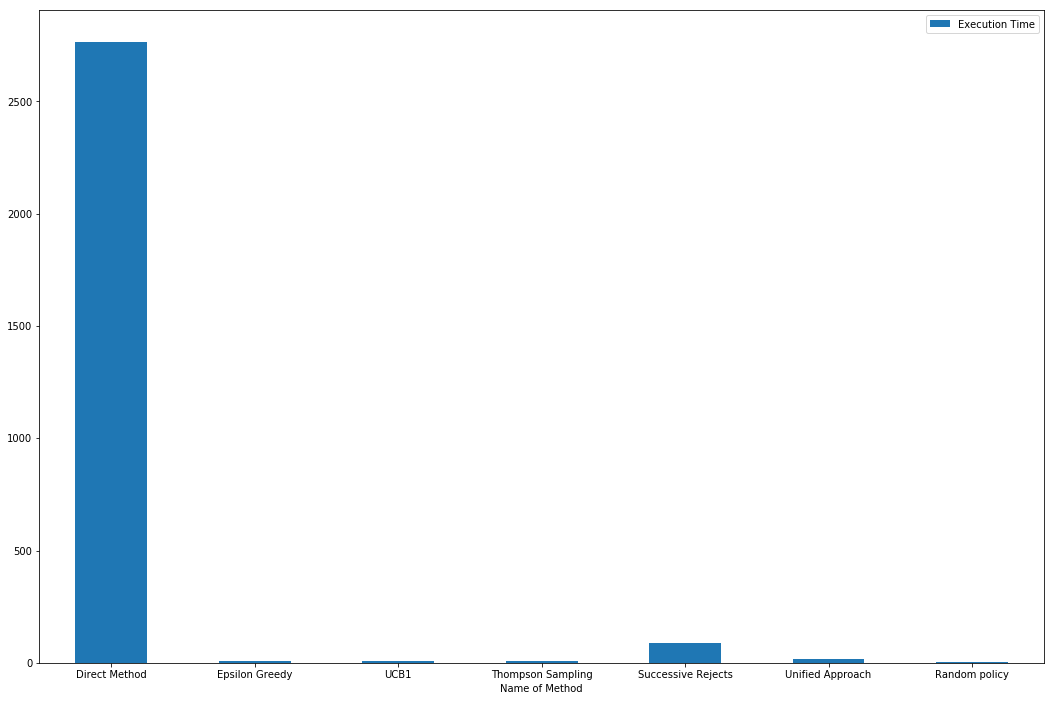

In [34]:
plt.rcParams['figure.figsize'] = (18, 12)
df_time.plot.bar(x='Name of Method', y='Execution Time', rot=0);

## Execution time for different methods _not_ including Direct Method

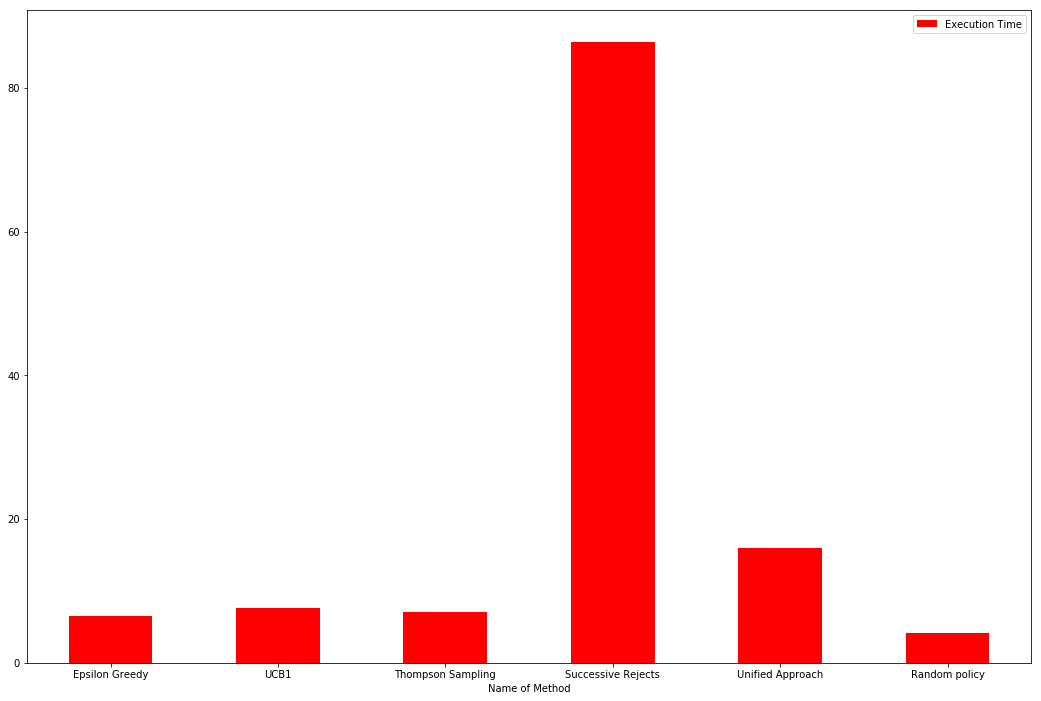

In [35]:
Time = {'Name of Method': ["Epsilon Greedy", "UCB1", "Thompson Sampling", "Successive Rejects","Unified Approach","Random policy"], 
        'Execution Time': [endG - startG, endU - startU, endT - startT, endS - startS, endUB - startUB, endP - startP]}
df_time = pd.DataFrame.from_dict(Time)
plt.rcParams['figure.figsize'] = (18, 12)
df_time.plot.bar(x='Name of Method', y='Execution Time', rot=0, color ='red');

## Compute Spearman’s rank correlation

This method has been used in the paper [1] (ICLR 2017 paper from NVIDIA) to compare the different pruning methods compare to the direct (oracle) method as following:

Given the difference between the direct method and other method, $ d_i = rank(\theta _d(i) - rand( \theta _{other}(i))$ for each parameter $i$, the rank correlation is computer:

$ S = 1 - \frac{6}{N(N^2-1)} \sum_{i=1}^{N} d_{i}^{2}$



[1] https://arxiv.org/pdf/1611.06440.pdf


In [36]:
df_D = pd.DataFrame({"Weights_Direct":N_arryD})
df_G = pd.DataFrame({"Weights_E_Greedy":Avg_Accumaltive_R_EGN})
df_U = pd.DataFrame({"Weights_UCB":Avg_Accumaltive_UCB}) 
df_T = pd.DataFrame({"Weights_TS":Avg_Accumaltive_TS}) 
df_S = pd.DataFrame({"Weights_SR":Avg_Accumaltive_SR3})
df_UB = pd.DataFrame({"Weights_SR":Avg_Accumaltive_UB})
df_RP = pd.DataFrame({"Weights_SR":Avg_Accumaltive_RP})

df_D["Direct Rank"] = df_D.rank(method='max')
df_G["E_Greedy Rank"] = df_G.rank(method='max')
df_U["UCB Rank"] = df_U.rank(method='max')
df_T["TS Rank"] = df_T.rank(method='max')
df_S["SR Rank"] = df_S.rank(method='max')

In [37]:
df_D["Direct Rank"] = df_D.rank()
df_G["E_Greedy Rank"] = df_G.rank()
df_U["UCB Rank"] = df_U.rank()
df_T["TS Rank"] = df_T.rank()
df_S["SR Rank"] = df_S.rank()
df_UB["Unified Approach"] = df_UB.rank()
df_RP["Random policy"] = df_RP.rank()

In [38]:
df_D["d E_Greedy"] = df_D["Direct Rank"] - df_G["E_Greedy Rank"]
df_D["d UCB"] = df_D["Direct Rank"] - df_U["UCB Rank"]
df_D["d TS"] = df_D["Direct Rank"] - df_T["TS Rank"]
df_D["d SR"] = df_D["Direct Rank"] - df_S["SR Rank"]
df_D["d UB"] = df_D["Direct Rank"] - df_UB["Unified Approach"]
df_D["d RP"] = df_D["Direct Rank"] - df_RP["Random policy"]

In [39]:
df_D["d square E_Greedy"] = df_D["d E_Greedy"] * df_D["d E_Greedy"]
df_D["d square UCB"] = df_D["d UCB"] * df_D["d UCB"]
df_D["d square TS"] = df_D["d TS"] * df_D["d TS"]
df_D["d square SR"] = df_D["d SR"] * df_D["d SR"]
df_D["d square UB"] = df_D["d UB"] * df_D["d UB"]
df_D["d square RP"] = df_D["d RP"] * df_D["d RP"]

In [40]:
S_E_greedy = 1 - 6/(N1*N2*((N1*N2)**2 - 1)) * df_D["d square E_Greedy"].sum()
S_UCB = 1 - 6/(N1*N2*((N1*N2)**2 - 1)) * df_D["d square UCB"].sum()
S_TS = 1 - 6/(N1*N2*((N1*N2)**2 - 1)) * df_D["d square TS"].sum()
S_SR = 1 - 6/(N1*N2*((N1*N2)**2 - 1)) * df_D["d square SR"].sum()
S_UB = 1 - 6/(N1*N2*((N1*N2)**2 - 1)) * df_D["d square UB"].sum()
S_RP = 1 - 6/(N1*N2*((N1*N2)**2 - 1)) * df_D["d square RP"].sum()

In [41]:
data = {'Name of Method': ["Epsilon Greedy", "UCB1", "Thompson Sampling", "Successive Rejects","Unified Approach", "Random policy"], 'Spearman rank correlation': [S_E_greedy, S_UCB, S_TS, S_SR, S_UB, S_RP]}
df_cor = pd.DataFrame.from_dict(data)

In [42]:
df_cor

,Name of Method,Spearman rank correlation
0,Epsilon Greedy,0.560879
1,UCB1,0.578908
2,Thompson Sampling,0.578923
3,Successive Rejects,0.143810
4,Unified Approach,0.591007
5,Random policy,0.476191


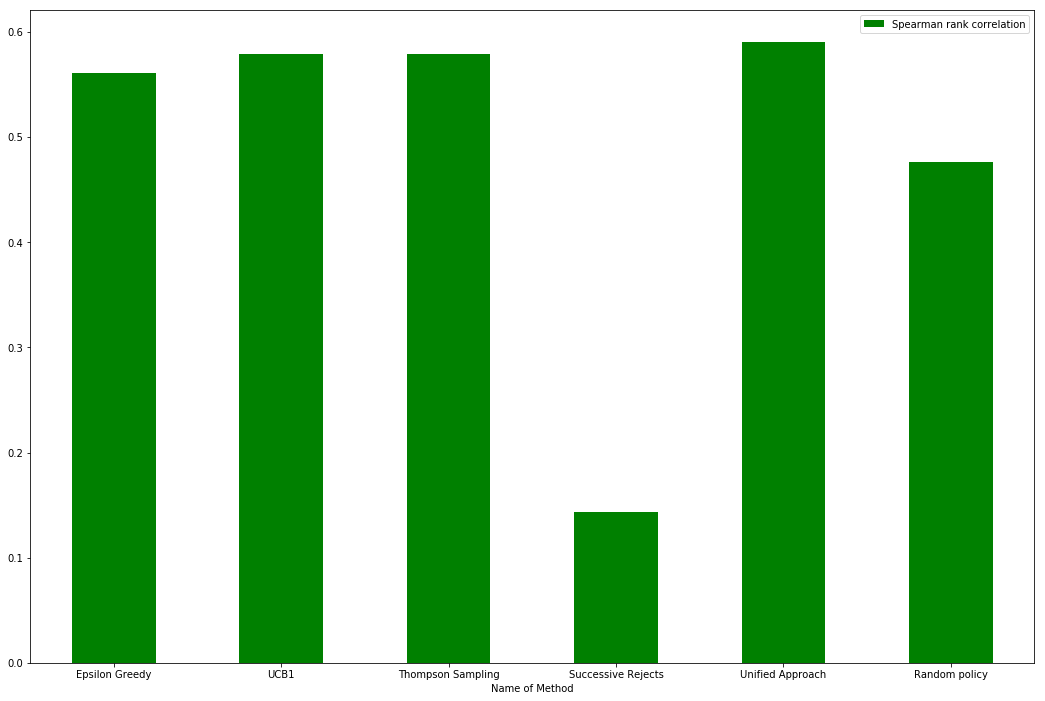

In [43]:
plt.rcParams['figure.figsize'] = (18, 12)
df_cor.plot.bar(x='Name of Method', y='Spearman rank correlation', rot=0, color='green');